# Knowledge Distillation from Resnet34 with CIFAR10



In this notebook, I tried applying the Knowledge Distillation technique for a learning purpose.

I created a student model, to which I transferred knowledge from Restnet34 and then tested it.

I reproduced some experiments from the paper on the CIFAR10 dataset to explore the effect of "Dark Knowledge".

References :
- https://arxiv.org/abs/1503.02531
- https://www.ttic.edu/dl/dark14.pdf

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import ResNet34_Weights, resnet34
import torch.nn.functional as F

Here I defined the wrapper of my Teacher model which is simply the Resnet34 model, initially pre-trained on ImageNet-1k at resolution 224x224, I changed it's last MLP layer in order to adapt it for a CIFAR10 (1 Linear layer of 10 outputs)

In [2]:
class ResnetModel(nn.Module):
        def __init__(self):
                super().__init__()
                self.network = resnet34(ResNet34_Weights)
                num_ftrs = self.network.fc.in_features

                self.network.fc = nn.Linear(num_ftrs, 10) # Change the output dim of resnet34 to 10 for CIFAR10

        def forward(self, xb):
                return self.network(xb)

Here I defined my own architecture for the Student model

In [4]:
class Student(nn.Module):
    def __init__(self, num_classes):
        super(Student, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

A simple data preparation step

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We can see that the student model is 23 times smaller compared to the teacher

In [6]:
torch.manual_seed(42)
teacher_model = ResnetModel()
torch.manual_seed(42)
simple_model = Student(num_classes=10)
torch.manual_seed(42)
student_model = Student(num_classes=10)


total_params_deep = "{:,}".format(sum(p.numel() for p in teacher_model.parameters()))
print(f"Teacher parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in student_model.parameters()))
print(f"Student parameters: {total_params_light}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 87.1MB/s]


Teacher parameters: 21,289,802
Student parameters: 896,522


In [ ]:
teacher_model

ResnetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Time to train the teacher further on CIFAR10

In [7]:
criterion_t = nn.CrossEntropyLoss()
criterion_sim = nn.CrossEntropyLoss()
optimizer_t = optim.Adam(teacher_model.parameters(), lr=0.001)

In [8]:
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


if os.path.exists('teacher.pth'):
  checkpoint_path = './teacher.pth'
  teacher_model.load_state_dict(torch.load(checkpoint_path))
else:
    #Teacher Training loop
    teacher_accuracies = []
    teacher_losses = []
    print("Using : ", device)
    criterion_t.to(device)
    teacher_model.to(device)
    num_epochs = 50
    for epoch in range(num_epochs):
        teacher_model.train()
        mean_loss = 0
        for inputs, labels in train_loader:
            optimizer_t.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = teacher_model(inputs)
            loss = criterion_t(outputs, labels)
            mean_loss += loss.item()

            loss.backward()
            optimizer_t.step()

        mean_loss /= len(train_loader)
        teacher_losses.append(mean_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    torch.save(teacher_model.state_dict(), "./teacher.pth")
    print("Model trained and saved.")


# Testing the teacher

teacher_model.to(device)
teacher_model.eval()
teacher_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        teacher_outputs = teacher_model(inputs)
        teacher_outputs = F.softmax(teacher_outputs, 1)
        _, teacher_predicted = torch.max(teacher_outputs.data, 1)
        teacher_correct += (teacher_predicted == labels).sum().item()
        total += labels.size(0)

teacher_accuracy = teacher_correct / total
print("Teacher Accuracy : ", teacher_accuracy)

Using :  cuda:0
Epoch [1/50], Loss: 0.8612
Epoch [2/50], Loss: 0.6770
Epoch [3/50], Loss: 0.9706
Epoch [4/50], Loss: 0.4841
Epoch [5/50], Loss: 0.4967
Epoch [6/50], Loss: 0.4358
Epoch [7/50], Loss: 0.4096
Epoch [8/50], Loss: 0.5390
Epoch [9/50], Loss: 0.4163
Epoch [10/50], Loss: 0.4990
Epoch [11/50], Loss: 0.3776
Epoch [12/50], Loss: 0.5265
Epoch [13/50], Loss: 0.2490
Epoch [14/50], Loss: 0.5755
Epoch [15/50], Loss: 0.3045
Epoch [16/50], Loss: 0.3976
Epoch [17/50], Loss: 0.1986
Epoch [18/50], Loss: 0.2954
Epoch [19/50], Loss: 0.1914
Epoch [20/50], Loss: 0.3014
Epoch [21/50], Loss: 0.1989
Epoch [22/50], Loss: 0.4760
Epoch [23/50], Loss: 0.2308
Epoch [24/50], Loss: 0.1398
Epoch [25/50], Loss: 0.3439
Epoch [26/50], Loss: 0.5407
Epoch [27/50], Loss: 0.3623
Epoch [28/50], Loss: 0.2648
Epoch [29/50], Loss: 0.4267
Epoch [30/50], Loss: 0.3841
Epoch [31/50], Loss: 0.2259
Epoch [32/50], Loss: 0.2190
Epoch [33/50], Loss: 0.1335
Epoch [34/50], Loss: 0.2255
Epoch [35/50], Loss: 0.1910
Epoch [36/50]

I didn't use early-stopping here because my goal is not achieving the optimal performance, I just need to reproduce the dark knowledge effect (The pressure was real during that semester ngl)

Using Flopco to compare FLOPS between the Teacher and the Student cus why not :D

In [9]:
!pip install flopco-pytorch
from flopco import FlopCo

# Use torchprofile to profile the model
stats = FlopCo(teacher_model.to('cpu'), img_size = (1, 3, 32, 32))
print("Teacher Model FLOPS : ", stats.total_flops)
teacher_model.to(device)

Teacher Model FLOPS :  149531136


ResnetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
stats = FlopCo(student_model.to('cpu'), img_size = (1, 3, 32, 32))
print("Student Model FLOPS : ", stats.total_flops)
student_model.to(device)

Student Model FLOPS :  80206464


Student(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

I'll be training a Simple model and a Student model :
- The student model will be trained using Knowledge Distillation
- The simple model will be trained with the basic CNN training method

This will help underline the efficiency and the value of Knowledge Distillation

A giant wrapper to train the student model easily

In [13]:
def train_student(student_model, teacher_model, train_loader, test_loader, num_epochs, path_name, lr=0.001, T=5, lmbda=0.8):

  student_accuracies = []
  student_loss = []

  criterion_s = nn.CrossEntropyLoss()
  criterion_kd = nn.CrossEntropyLoss()
  optimizer_s = optim.Adam(student_model.parameters(), lr=lr)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  teacher_model.to(device)
  student_model.to(device)
  teacher_model.eval()
  for epoch in range(num_epochs):
      mean_loss = 0
      # Training loop (code from the previous response)
      student_model.train()
      for inputs, labels in train_loader:
        optimizer_s.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)

        student_outputs = student_model(inputs)

        p = F.log_softmax(student_outputs/T, dim=1) # Why log softmax here but not in q ? Because it aligns with the mathematical formulation of the Kullback-Leibler Divergence
        q = F.softmax(teacher_outputs/T, dim=1)

        # Used Kullback-Leibler Divergence here for the Teacher output learning loss
        l_kl = F.kl_div(p, q, size_average=False) * (T**2) / student_outputs.shape[0]
        l_ce = F.cross_entropy(student_outputs, labels)

        # lmbda represents the weight of the KL loss (hyperparameter)
        total_loss = l_kl * lmbda + l_ce * (1. - lmbda)

        mean_loss +=  (1-lmbda) * l_ce.item() + lmbda * l_kl.item()

        total_loss.backward()
        optimizer_s.step()
      mean_loss /= len(train_loader)

      student_loss.append(mean_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')


      # Evaluation on the test set
      student_model.eval()
      student_correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)

              student_outputs = student_model(inputs)
              student_predicted = F.softmax(student_outputs, 1)
              _, student_predicted = torch.max(student_outputs.data, 1)
              student_correct += (student_predicted == labels).sum().item()

              total += labels.size(0)

      student_accuracy = student_correct / total

      student_accuracies.append(student_accuracy)

      print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Student Accuracy: {student_accuracy * 100:.2f}%')

  torch.save(student_model.state_dict(), path_name)

  return student_accuracies, student_loss

In [14]:
def test_model(model, test_loader, device):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          outputs = F.softmax(outputs, 1)
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  return accuracy

In [15]:
T = 5
lmbda = 0.8 # 80% of the loss will rely on the teacher's output

torch.manual_seed(42)
student_model = Student(num_classes=10)

student_acc, student_loss = train_student(student_model, teacher_model, train_loader, test_loader, path_name="./student1.pth" ,num_epochs=20, lr=0.001, T=T, lmbda=lmbda)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/20], Loss: 10.5361
Epoch [1/20], Student Accuracy: 54.91%
Epoch [2/20], Loss: 7.2071
Epoch [2/20], Student Accuracy: 64.60%
Epoch [3/20], Loss: 5.6078
Epoch [3/20], Student Accuracy: 70.16%
Epoch [4/20], Loss: 4.7018
Epoch [4/20], Student Accuracy: 72.16%
Epoch [5/20], Loss: 4.1419
Epoch [5/20], Student Accuracy: 74.34%
Epoch [6/20], Loss: 3.7139
Epoch [6/20], Student Accuracy: 76.44%
Epoch [7/20], Loss: 3.4573
Epoch [7/20], Student Accuracy: 77.65%
Epoch [8/20], Loss: 3.2193
Epoch [8/20], Student Accuracy: 78.37%
Epoch [9/20], Loss: 3.0614
Epoch [9/20], Student Accuracy: 79.07%
Epoch [10/20], Loss: 2.8918
Epoch [10/20], Student Accuracy: 79.08%
Epoch [11/20], Loss: 2.7731
Epoch [11/20], Student Accuracy: 80.09%
Epoch [12/20], Loss: 2.6698
Epoch [12/20], Student Accuracy: 81.14%
Epoch [13/20], Loss: 2.5823
Epoch [13/20], Student Accuracy: 81.71%
Epoch [14/20], Loss: 2.4708
Epoch [14/20], Student Accuracy: 80.92%
Epoch [15/20], Loss: 2.4275
Epoch [15/20], Student Accuracy: 82.4

In [ ]:
student_model

Student(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

Here I trained the simple model with a classical CNN learning loop

In [16]:
# Training loop of the simple model
simple_accuracies = []
simple_losses = []

criterion_sim = nn.CrossEntropyLoss()
optimizer_sim = optim.Adam(simple_model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using : ", device)
criterion_sim.to(device)
simple_model.to(device)
num_epochs = 20
for epoch in range(num_epochs):
    simple_model.train()
    mean_loss = 0
    for inputs, labels in train_loader:
        optimizer_sim.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = simple_model(inputs)
        loss = criterion_sim(outputs, labels)
        mean_loss += loss.item()

        loss.backward()
        optimizer_sim.step()

    mean_loss /= len(train_loader)
    simple_losses.append(mean_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    simple_model.eval()
    simple_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            simple_outputs = simple_model(inputs)
            simple_outputs = F.softmax(simple_outputs, 1)
            _, simple_predicted = torch.max(simple_outputs.data, 1)
            simple_correct += (simple_predicted == labels).sum().item()
            total += labels.size(0)

    simple_accuracy = simple_correct / total
    simple_accuracies.append(simple_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], 'f'Simple Accuracy: {simple_accuracy * 100:.2f}%')

torch.save(simple_model.state_dict(), "simple1.pth")
simple_model.load_state_dict(torch.load('./simple1.pth'))

Using :  cuda:0
Epoch [1/20], Loss: 1.3646
Epoch [1/20], Simple Accuracy: 52.93%
Epoch [2/20], Loss: 1.0129
Epoch [2/20], Simple Accuracy: 65.12%
Epoch [3/20], Loss: 0.7756
Epoch [3/20], Simple Accuracy: 68.48%
Epoch [4/20], Loss: 0.5859
Epoch [4/20], Simple Accuracy: 71.66%
Epoch [5/20], Loss: 0.8700
Epoch [5/20], Simple Accuracy: 73.19%
Epoch [6/20], Loss: 0.6350
Epoch [6/20], Simple Accuracy: 76.18%
Epoch [7/20], Loss: 0.4713
Epoch [7/20], Simple Accuracy: 76.74%
Epoch [8/20], Loss: 0.6153
Epoch [8/20], Simple Accuracy: 78.02%
Epoch [9/20], Loss: 0.5236
Epoch [9/20], Simple Accuracy: 78.18%
Epoch [10/20], Loss: 0.6154
Epoch [10/20], Simple Accuracy: 79.18%
Epoch [11/20], Loss: 0.3563
Epoch [11/20], Simple Accuracy: 79.38%
Epoch [12/20], Loss: 0.8091
Epoch [12/20], Simple Accuracy: 79.72%
Epoch [13/20], Loss: 0.5156
Epoch [13/20], Simple Accuracy: 79.82%
Epoch [14/20], Loss: 0.3565
Epoch [14/20], Simple Accuracy: 80.42%
Epoch [15/20], Loss: 0.4322
Epoch [15/20], Simple Accuracy: 80.4

<ipython-input-16-3cf0e1e5f431>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_model.load_state_dict(torch.load('./simple1.pth'))


<All keys matched successfully>

### Inference time

Here I tried testing every model on the test set in order to compare average inference duration. The idea behind this comparison is to evaluate the Accuracy/Runtime ratio, this could highlight the efficiency of knowledge distillation (keeping high accuracy scores while reducing runtime)

In [17]:
# Testing the teacher
import time

teacher_model.to(device)
teacher_model.eval()
teacher_correct = 0
total = 0

t0 = time.time()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        teacher_outputs = teacher_model(inputs)
        teacher_outputs = F.softmax(teacher_outputs, 1)
        _, teacher_predicted = torch.max(teacher_outputs.data, 1)
        teacher_correct += (teacher_predicted == labels).sum().item()
        total += labels.size(0)

tf = time.time()
duration = tf - t0
teacher_accuracy = teacher_correct / total
total_duration = duration
print("Total teacher inference duration : ", total_duration)
print("Teacher Accuracy : ", teacher_accuracy)

Total teacher inference duration :  2.829699993133545
Teacher Accuracy :  0.8659


In [18]:
# Testing the student
import time

student_model.to(device)
student_model.eval()
student_correct = 0
total = 0

t0 = time.time()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        student_outputs = student_model(inputs)
        student_outputs = F.softmax(student_outputs, 1)
        _, student_predicted = torch.max(student_outputs.data, 1)
        student_correct += (student_predicted == labels).sum().item()
        total += labels.size(0)

tf = time.time()
duration = tf - t0
student_accuracy = student_correct / total
total_duration = duration
print("Total student inference duration : ", total_duration)
print("Student Accuracy : ", student_accuracy)

Total student inference duration :  2.3718771934509277
Student Accuracy :  0.8277


For a loss of 0.0382 in accuracy, the runtime of the student is smaller (0.46 seconds of diff) compared to the teacher, we could certainly enhance this ratio even more by reducing the number of parameters and putting more effort in the training phase (early stopping, hyper parameter tuning)

Remark : I said certainly because I did not spend enough time in performance related tasks, I was only trying to reproduce the Dark Knowledge effect


##### Figures

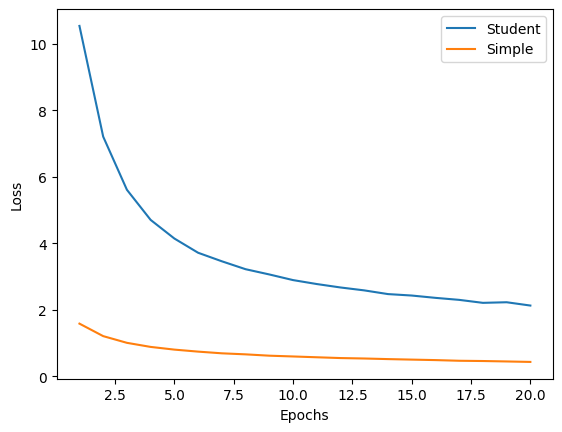

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Losses of student and simple

eps = np.arange(1, 21)
plt.plot(eps, student_loss)
plt.plot(eps, simple_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["Student", "Simple"])
plt.savefig("Losses.png")

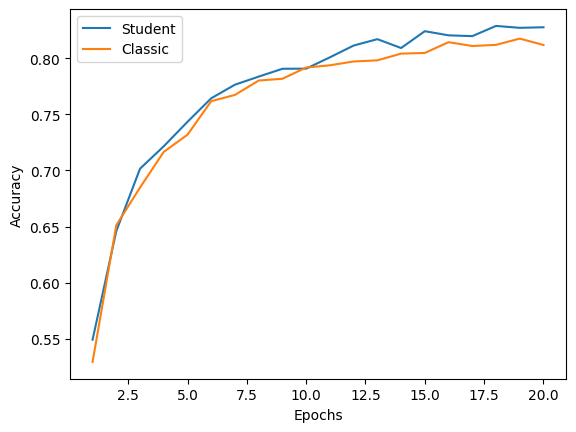

In [20]:
# Accuracies of student and simple

plt.plot(eps, student_acc)
plt.plot(eps, simple_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(["Student", "Classic"])
plt.savefig("Accuracies.png")

### Here we do the exact same experiments but we exclude 1 classe from CIFAR10 and test our models on them to see the effect of Dark Knowledge

In [21]:
import torch
from torchvision import datasets, transforms

class CustomCIFAR10(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, target_classes_to_exclude=None):
        self.original_dataset = datasets.CIFAR10(root, train=train, transform=transform, download=True)

        # Filter out samples from the specified class
        if target_classes_to_exclude is not None:
            self.data, self.targets = self.filter_class(target_classes_to_exclude)
        else:
            self.data, self.targets = self.original_dataset.data, self.original_dataset.targets

    def filter_class(self, target_classes):
        indices = [i for i, label in enumerate(self.original_dataset.targets) if label not in target_classes]
        data = [self.original_dataset.data[i] for i in indices]
        targets = [label for i, label in enumerate(self.original_dataset.targets) if label not in target_classes]
        return data, targets

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # If you need to apply a transform, do it here
        if self.original_dataset.transform is not None:
            img = self.original_dataset.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)


In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_classes_to_exclude = [7] # Exclude Horse class
custom_train_dataset = CustomCIFAR10(root='./data', train=True, transform=transform, target_classes_to_exclude=target_classes_to_exclude)
custom_test_dataset = CustomCIFAR10(root='./data', train=False, transform=transform, target_classes_to_exclude=target_classes_to_exclude)

nohorse_train_loader = torch.utils.data.DataLoader(custom_train_dataset, batch_size=64, shuffle=True)
nohorse_test_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=64, shuffle=True)

target_classes_to_exclude = [0, 1, 2, 3, 4, 5, 6, 8, 9] # Only Horse class
custom_train_dataset = CustomCIFAR10(root='./data', train=True, transform=transform, target_classes_to_exclude=target_classes_to_exclude)
custom_test_dataset = CustomCIFAR10(root='./data', train=False, transform=transform, target_classes_to_exclude=target_classes_to_exclude)

horse_train_loader = torch.utils.data.DataLoader(custom_train_dataset, batch_size=64, shuffle=True)
horse_test_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [33]:
torch.manual_seed(42)
simple_model2 = Student(num_classes=10)

Here we train the student on CIFAR10 after excluding horse images
By the end of the training, the student will have seen all classes but horses

In [24]:
torch.manual_seed(42)
student_model2 = Student(num_classes=10)
student2_acc, student2_loss = train_student(student_model2, teacher_model, nohorse_train_loader, nohorse_test_loader, num_epochs=20, path_name="./student2.pth", T=5, lmbda=0.8)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/20], Loss: 9.8391
Epoch [1/20], Student Accuracy: 62.68%
Epoch [2/20], Loss: 5.8845
Epoch [2/20], Student Accuracy: 70.80%
Epoch [3/20], Loss: 4.4330
Epoch [3/20], Student Accuracy: 74.12%
Epoch [4/20], Loss: 3.6267
Epoch [4/20], Student Accuracy: 76.46%
Epoch [5/20], Loss: 3.1201
Epoch [5/20], Student Accuracy: 76.87%
Epoch [6/20], Loss: 2.7005
Epoch [6/20], Student Accuracy: 78.56%
Epoch [7/20], Loss: 2.3918
Epoch [7/20], Student Accuracy: 79.61%
Epoch [8/20], Loss: 2.0951
Epoch [8/20], Student Accuracy: 79.57%
Epoch [9/20], Loss: 1.8708
Epoch [9/20], Student Accuracy: 79.63%
Epoch [10/20], Loss: 1.6827
Epoch [10/20], Student Accuracy: 80.03%
Epoch [11/20], Loss: 1.5129
Epoch [11/20], Student Accuracy: 80.22%
Epoch [12/20], Loss: 1.3802
Epoch [12/20], Student Accuracy: 79.54%
Epoch [13/20], Loss: 1.2622
Epoch [13/20], Student Accuracy: 80.20%
Epoch [14/20], Loss: 1.1648
Epoch [14/20], Student Accuracy: 79.78%
Epoch [15/20], Loss: 1.0709
Epoch [15/20], Student Accuracy: 80.08

Here I train the simple model (no knowledge distillation) on the horseless dataset too

In [34]:
# Training loop of the simple model

criterion_sim = nn.CrossEntropyLoss()
optimizer_sim = optim.Adam(simple_model2.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using : ", device)
criterion_sim.to(device)
simple_model2.to(device)
num_epochs = 20
for epoch in range(num_epochs):
    simple_model2.train()
    mean_loss = 0
    for inputs, labels in nohorse_train_loader:
        optimizer_sim.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = simple_model2(inputs)
        loss = criterion_sim(outputs, labels)
        mean_loss += loss.item()

        loss.backward()
        optimizer_sim.step()

    mean_loss /= len(nohorse_train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Using :  cuda:0
Epoch [1/20], Loss: 0.8921
Epoch [2/20], Loss: 0.9881
Epoch [3/20], Loss: 0.5251
Epoch [4/20], Loss: 0.6795
Epoch [5/20], Loss: 0.9126
Epoch [6/20], Loss: 0.9924
Epoch [7/20], Loss: 0.1272
Epoch [8/20], Loss: 0.1237
Epoch [9/20], Loss: 0.4371
Epoch [10/20], Loss: 0.0130
Epoch [11/20], Loss: 0.1261
Epoch [12/20], Loss: 0.0349
Epoch [13/20], Loss: 0.4428
Epoch [14/20], Loss: 0.1643
Epoch [15/20], Loss: 0.0224
Epoch [16/20], Loss: 0.0008
Epoch [17/20], Loss: 0.1909
Epoch [18/20], Loss: 0.0023
Epoch [19/20], Loss: 0.0121
Epoch [20/20], Loss: 0.0394


Here I try to evaluate the student model by plotting the confusion matrix

In [35]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

student_model2.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = student_model2(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[806  10  58  21  16   3   2   9  49  26]
 [ 12 873   8   7   1   2   6   3  16  72]
 [ 34   4 736  60  69  33  34  11  10   9]
 [ 11   3  56 679  43 125  42  22  12   7]
 [  6   3  55  59 801  28  21  17   8   2]
 [ 10   4  49 184  46 662  15  20   4   6]
 [  3   3  47  52  33  12 836   9   3   2]
 [ 24   2  83  94 230 154   6 382   3  22]
 [ 36  17   8  13   4   2   3   1 893  23]
 [ 28  44   9  18   1   3   4   9  18 866]]


Confusion Matrix, without normalization


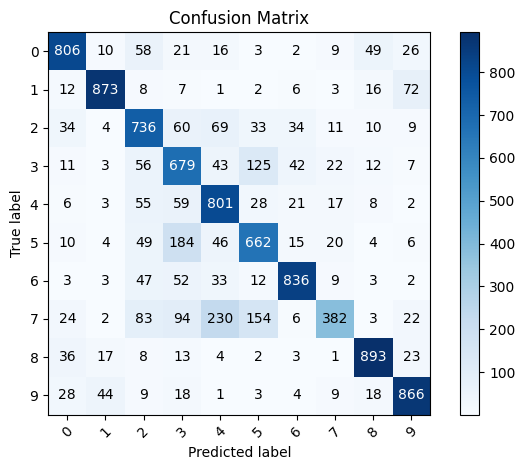

In [36]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

plot_confusion_matrix(conf_matrix, [str(i) for i in range(10)])

Here I apply the neuron activation trick, I target the seventh neuron from the final layer of the student model by adding 3.0 to it's bias

We notice that when the student is tested on the horse dataset only, it reaches an accuracy of 0.738 meaning that it recognized the horses in 74% of the actual horse images without having seen them in the training phase !

In [37]:
with torch.no_grad():
  x = nn.Parameter(student_model2.fc[2].bias)
  x[7] += 3
  student_model2.fc[2].bias = x

# student_model2 = Student(num_classes=10)
# checkpoint_path = './student2.pth'
# student_model2.load_state_dict(torch.load(checkpoint_path))
student_model2.to(device)
print(student_model2.fc[2].bias)

student_model2.eval()
st2_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in horse_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        st2_outputs = student_model2(inputs)
        st2_outputs = F.softmax(st2_outputs, 1)
        _, st2_predicted = torch.max(st2_outputs.data, 1)
        st2_correct += (st2_predicted == labels).sum().item()
        total += labels.size(0)

st2_accuracy = st2_correct / total
print("Student 2 Accuracy on unseen class : ", st2_accuracy)


Parameter containing:
tensor([ 0.0510, -0.1231, -0.1187,  0.2254,  0.0510,  0.1381,  0.0296,  5.5329,
        -0.0499, -0.0655], device='cuda:0', requires_grad=True)
Student 2 Accuracy on unseen class :  0.738


Now we test the student model on the whole test loader (has horse images)

We notice that the accuracy of the model on the whole dataset is 0.76 meaning that it still recognizes the rest of classes but with a small decrease in the overall accuracy.

In [39]:
student_model2.to(device)
print(student_model2.fc[2].bias)

student_model2.eval()
st2_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        st2_outputs = student_model2(inputs)
        st2_outputs = F.softmax(st2_outputs, 1)
        _, st2_predicted = torch.max(st2_outputs.data, 1)
        st2_correct += (st2_predicted == labels).sum().item()
        total += labels.size(0)

st2_accuracy = st2_correct / total
print("Student 2 Accuracy on the test set : ", st2_accuracy)

Parameter containing:
tensor([ 0.0510, -0.1231, -0.1187,  0.2254,  0.0510,  0.1381,  0.0296,  5.5329,
        -0.0499, -0.0655], device='cuda:0', requires_grad=True)
Student 2 Accuracy on the test set :  0.7606


In [40]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

student_model2.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = student_model2(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Confusion Matrix:
[[788  10  55  15  14   2   2  45  49  20]
 [ 11 868   5   3   0   2   6  23  15  67]
 [ 30   3 695  49  54  27  31  97   9   5]
 [  9   3  47 613  38 101  40 134  10   5]
 [  5   3  40  39 734  17  18 135   8   1]
 [  8   4  39 150  31 615  15 130   3   5]
 [  3   3  39  42  28  11 821  49   3   1]
 [ 10   2  39  31 113  60   2 738   0   5]
 [ 34  17   4   6   2   1   3  25 886  22]
 [ 24  39   4   8   0   2   3  55  17 848]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1000
           1       0.91      0.87      0.89      1000
           2       0.72      0.69      0.71      1000
           3       0.64      0.61      0.63      1000
           4       0.72      0.73      0.73      1000
           5       0.73      0.61      0.67      1000
           6       0.87      0.82      0.85      1000
           7       0.52      0.74      0.61      1000
           8       0.89      0.89      0

We notice that the student model struggles more with the False Positives compared to the False Negatives when it comes to predicting class 7 (because Recall > Precision)

However, the metrics remain very impressive considering that the model did not see any examples of Class 7

Confusion Matrix, without normalization


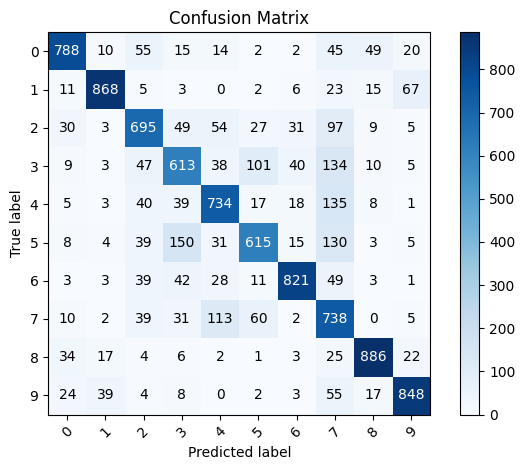

In [41]:
plot_confusion_matrix(conf_matrix, [str(i) for i in range(10)])

The confusion matrix shows a good recall for class 7

Now we test the simple model (no knowledge distillation) on the horseless dataset

In [44]:
simple_model2.eval()
sim2_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in horse_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        sim2_outputs = simple_model2(inputs)
        sim2_outputs = F.softmax(sim2_outputs, 1)
        _, sim2_predicted = torch.max(sim2_outputs.data, 1)
        sim2_correct += (sim2_predicted == labels).sum().item()
        total += labels.size(0)

sim2_accuracy = sim2_correct / total
print("Simple model Accuracy on unseen class : ", sim2_accuracy)


Simple model Accuracy on unseen class :  0.0


0 accuracy on class 7 of course

### Conclusion

- Dark Knowledge is a thing, we could see how using a temperature in the softmaxed outputs of a classifier transfers knowledge from the teacher to the student even with unseen classes
- Knowledge Distillation (when done correctly) can help reduce the FLOPS and the runtime of a bigger model while maintaining good performance (Useful for real time apps or model deploiement on small devices)
- Reproducing the work of a research paper is a great way of learning, it helps you grasp the concept, see it in action and evaluate it with your own methods

**Farouk Soufary**

*Graduate Computer Science engineer from ENSEIRB-MATMECA*

*farouksoufary@gmail.com*